# Проект: вариант 2
## Задание 1. A/B–тестирование

### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?

Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

### 1.4 Требования к ответу

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

## Решение


### План:
- Посмотрим на данные
- Выберем метрику, сформулируем гипотезы, исходя из общей задачи
- Выбираем подходящий тест
- Тестируем
- Подводим итоги

In [1]:
# импортируем библиотеки

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
plt.style.use('ggplot')


from scipy.stats import norm

%matplotlib inline

import requests
from urllib.parse import urlencode


sns.set(rc={'figure.figsize': (12, 6)}, style="whitegrid")

# from scipy import stats
# import plotly.express as px
# import scipy.stats as ss

In [2]:
# загрузка с яндекс диска
groups_data = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_data = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_data = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_data = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [3]:
# функция для получения данных с яндекс диска

def download(url):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=url))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [4]:
# загружаем данные
groups = pd.read_csv(download(groups_data), sep=';')
groups_add = pd.read_csv(download(groups_add_data))
active_studs = pd.read_csv(download(active_studs_data))
checks = pd.read_csv(download(checks_data), sep=';')

#### данные для юпитера, если диск не работает

groups = pd.read_csv('groups.csv', sep = ';')
groups_add = pd.read_csv('group_add.csv') 
active_studs = pd.read_csv('active_studs.csv') 
checks = pd.read_csv('checks.csv', sep = ';')

In [5]:
# проверяем что все загрузилось правильно

In [6]:
groups.head(2)

,id,grp
0,1489,B
1,1627,A


In [7]:
groups_add.head(2)

,id,grp
0,5694584,B
1,5694830,B


In [8]:
active_studs.head(2)

,student_id
0,581585
1,5723133


In [9]:
checks.head(2)

,student_id,rev
0,1627,990.0
1,3185,690.0


In [10]:
# проверим размер датасетов

In [11]:
groups.shape

(74484, 2)

In [12]:
groups_add.shape

(92, 2)

In [13]:
active_studs.shape

(8341, 1)

In [14]:
checks.shape

(541, 2)

In [15]:
# Проверим, есть ли совпадающие id в двух датасетах. 
set(groups.id).intersection(groups_add.id)

set()

In [16]:
set(groups.id) & set(groups_add.id)

set()

Совпадений среди двух датасетов нет, значит в "groups_add" точно находятся дополнительные id. Поэтому можно добавить их к  “groups”.

#### Вывод из описания данных
Исходя из описания данных и задания можно предположить, что в ходе проведения A/B теста нам понадобятся все датасеты. 

Основным датасетом будет “groups”, в котором находится информация о принадлежности пользователя к контрольной или экспериментальной группе. Однако, судя по размерам датасетов далеко не все пользователи заходили на сайт в дни проведения эксперимента, и их будет некорректно использовать для анализа новой механики оплаты на сайте.  Поэтому нужно будет провести корректировку датасета “groups” в соответствии с “active_studs” так, чтобы остались только "active_studs". Так как информация об оплате находится в датасете “checks”, то его тоже нужно будет присоединить. Можем предположить, что тем пользователям, у которых нет информации об оплате не понравилась новая механика оплаты, а тем кто заплатил, понравилась. 

Также, есть файл с дополнительными пользователями "groups_add", который прислали спустя 2 дня после передачи данных. В нем пользователи также поделены на тестовые группы. Так как у нас не указаны даты проведения A/B тестирования, а также в файле checks нет дат произведения оплаты и student_id в обоих файлах не совпадают, то можно предположить, что файл с дополнительными данными относится к тому же тестированию. Поэтому я считаю, что их следует также использовать в анализе.

Соберем все файлы в один

In [17]:
groups_f = pd.concat([groups, groups_add])

In [18]:
# поменяла название столбца для мерджа
active_studs = active_studs.rename(columns={'student_id': 'id'})
checks = checks.rename(columns={'student_id': 'id'})

In [19]:
active_studs.head()

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [20]:
groups_f2 = pd.merge(active_studs, groups_f, how="left", on="id")

In [21]:
# размер датафрейма соответествует количеству строк из active_studs
groups_f2.shape

(8341, 2)

In [22]:
groups_full = pd.merge(groups_f2, checks, how="left", on="id")

In [23]:
groups_full.shape

(8341, 3)

"groups_full" Получили датафрейм с разбиением на тестовые группы и суммой покупки, только для тех пользователей которые зашли на сайт в период проведения теста

Изучим полученный датасет

In [24]:
groups_full.head()

,id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN


In [25]:
groups_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      8341 non-null   int64  
 1   grp     8341 non-null   object 
 2   rev     392 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 260.7+ KB


In [26]:
# все посетители зашли только один раз за время экспримента
groups_full.id.nunique()

8341

In [27]:
# заменим значения NaN на ноль в одном столбце rev
groups_full['rev'] = groups_full['rev'].fillna(0)

In [28]:
groups_full['rev'].describe()

count    8341.000000
mean       56.083683
std       309.620349
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      4650.000000
Name: rev, dtype: float64

In [29]:
groups_full.groupby('grp', as_index=False).id.count()

,grp,id
0,A,1538
1,B,6803


In [30]:
groups.groupby('grp', as_index=False).id.count()

,grp,id
0,A,14671
1,B,59813


 - Добавлю столбец с фактом покупки 'purchase', 1 - покупка была, 0 - покупки не было

In [31]:
groups_full['is_purchase'] = groups_full.rev.apply(lambda x: 1 if x > 0 else 0)

In [32]:
groups_full

,id,grp,rev,is_purchase
0,581585,A,0.0,0
1,5723133,A,0.0,0
2,3276743,B,0.0,0
3,4238589,A,0.0,0
4,4475369,B,0.0,0
...,...,...,...,...
8336,1794344,B,0.0,0
8337,296883,B,0.0,0
8338,3598448,B,0.0,0
8339,3610547,B,290.0,1


Распределение покупателей по группам не равномерное. Наблюдается значительный перекос в сторону целевой группы. Как в файле "groups", так и в active_studs, с содержимым которого предстоит дальше работать. Это не является препятствием к проведению A/B тестирования, однако следует обратить на это внимание. Возможно такое распределение было выбрано намеренно, или некорректно работает сплит-система. Следовательно для того, чтобы исключить последнее, нужно было до проведения А/В теста провести А/А тест.  

### Выберем метрику, сформулируем гипотезу

Скорее всего новая механика оплаты тестируется, чтобы повысить конверсию в покупку, поэтому целевая метрика - это конверсия в покупку. 
Сконверитровался пользователь или нет, определяется по факту покупки. Смотреть на сумму покупки смысла нет, так как мы тестируем именно систему оплаты, а разницы в сумме не ответит на вопрос, в отличии от факта покупки. Для этого в датасет был добавлен столбец с бинарными переменными, 1 - покупка была, 0 - покупки не было.



Сформулируем гипотезы:
* Нулевая. Изменение механики оплаты на сайте ни к чему не приведет, конверсия остается прежней.
* Альтернативная. Изменение приведет к повышению конверсии.  

In [33]:
groups_full

,id,grp,rev,is_purchase
0,581585,A,0.0,0
1,5723133,A,0.0,0
2,3276743,B,0.0,0
3,4238589,A,0.0,0
4,4475369,B,0.0,0
...,...,...,...,...
8336,1794344,B,0.0,0
8337,296883,B,0.0,0
8338,3598448,B,0.0,0
8339,3610547,B,290.0,1


In [34]:
cr = groups_full.groupby('grp', as_index=False)\
                .is_purchase.mean()\
                .rename(columns={'is_purchase': 'CR'})

In [35]:
# на всякий случай проверю правильность рассчитанной метрики
groups_full.query('grp == "A" and is_purchase == 1').count() / groups_full.query('grp == "A"').is_purchase.count()

id             0.050715
grp            0.050715
rev            0.050715
is_purchase    0.050715
dtype: float64

In [36]:
# на всякий случай проверю правильность рассчитанной метрики
groups_full.query('grp == "B" and is_purchase == 1').count() / groups_full.query('grp == "B"').is_purchase.count()

id             0.046156
grp            0.046156
rev            0.046156
is_purchase    0.046156
dtype: float64

In [37]:
cr

,grp,CR
0,A,0.050715
1,B,0.046156


<AxesSubplot:xlabel='grp', ylabel='CR'>

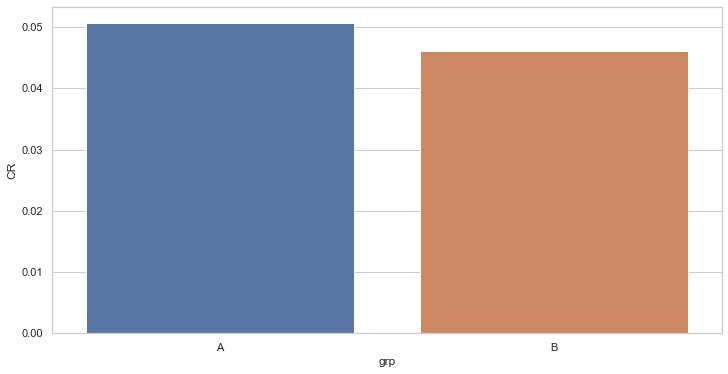

In [38]:
sns.barplot(data=cr, x="grp", y="CR")

При простом сравнении средней конверсии в группе, конверсия с новой механикой оплаты упала, по сравнению со старой механикой оплаты. Однако для подтверждения этой гипотезы следует использовать статистические тесты.

Скорректируем гипотезы: 

* Нулевая. Изменение механики оплаты на сайте ни к чему не приведет, конверсия остается прежней.
* Альтернативная. Новая механика оплаты приведет к изменению конверсии.  

### Выбор тестов 

Так как распределение биноминальное можно использовать несколько разных тестов. Я буду использовать следующие:

Хи-квадрат (или критерий согласия Пирсона). Критерий независимости наблюдений соблюден, пользователям показывали только один из вариантов оплаты. Количество наблюдений так же удовлетворяет требованию. 

Bootstrap средних. У Bootstrap почти нет никаких ограничений, кроме скорости на больших выборках, бутстрап при данной выборке будет выполняться не долго. Бутстрап можно применять для различных видов распределений и моделей.

Z test. Применяется для проверки средних значений между некоторыми выборками или для сравнения с определенным значением. Хорошо подходит для пропорций, как раз для конверсии. Требует независимости выборок и чтобы было известно стандартное отклонение.  

### Тестирование

#### Хи- квадрат  
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [39]:
pd.crosstab(groups_full.grp, groups_full.is_purchase)

is_purchase,0,1
grp,,
A,1460,78
B,6489,314


In [59]:
from scipy.stats import chi2_contingency

In [60]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(groups_full.grp, groups_full.is_purchase))

In [61]:
stat, p

(0.48480826522557896, 0.48625240457231045)

In [43]:
# Интерпретируем результат:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


Не отклоняем нулевую гипотезу для Хи-квадрата, значит взаимосвязи между переменными нет. То есть, изменение механики оплаты никак не влияет на изменение конверсии. 

#### Bootstrap средних 

- Н0: средние значения конверсии контрольной и эксприментальной группы равны
- Н1: средние значения конверсии контрольной и эксприментальной группы не равны

In [44]:
a = groups_full.query('grp == "A"').is_purchase
b = groups_full.query('grp == "B"').is_purchase

In [45]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

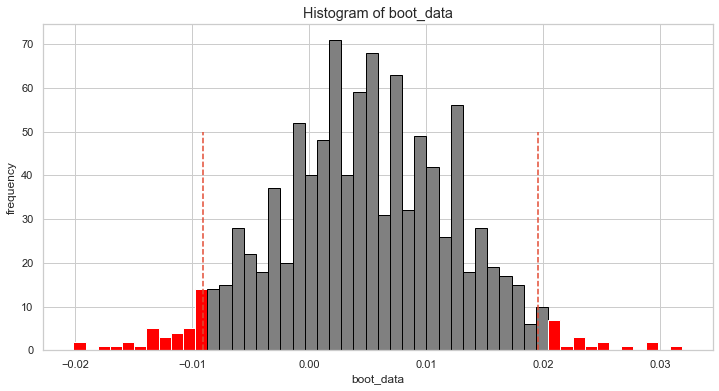

In [46]:
booted_data = get_bootstrap(a, b)

In [47]:
booted_data["p_value"]

0.5250489882360792

In [48]:
booted_data["quants"]

,0
0.025,-0.009103
0.975,0.019506


Значение p_value > 0.05 значит мы не отвергаем нулевую гипотезу. Доверительные границы включают 0, значит нулевая гипотеза на заданном уровне значимости принимается. Следовательно значение конверсии в двух группах не отличаются.

#### Z тест

Двусторонний Z-тест:

- Н0: средние значения конверсии контрольной и эксприментальной группы равны
- Н1: средние значения конверсии контрольной и эксприментальной группы не равны

In [49]:
from statsmodels.stats.proportion import proportions_ztest

In [50]:
proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])

(0.7629884495263746, 0.445470284371589)

Значение p_value > 0.05 значит мы не отвергаем нулевую гипотезу.

### Вывод

Были проанализированны данные проведенного А/В тестирования, в ходе которого тестировалась новая механика оплаты на сайте. В ходе анализа я опиралась на метрику конверсии в покупку, так как считаю, что она наиболее достоверно отражает предпочтение покупателей, нравится ли им механика оплаты на сайте или нет. Сравнение средней конверсии в двух группах показало ее падение с новой механикой оплаты, однако, чтобы получить достовеные данные нужно было провести статестические тесты. Я использовала Хи квадрат, Bootstrap и Z test. За нулевую гипотизу принималось то, что разницы в конверсии в друх группах нет, альтернативная, что разница есть. Все проведенные статистические тесты показали, что статистически значимых различий между двумя механиками оплаты нет. Это значит, что новая механика оплаты не изменит конверсию, а значит запускать новую механику оплаты в текущем виде на всех пользователей (без доработки) не имеет смысла. 

## Задание 3. Python

#### 3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
#### 3.2 Задача 

Реализуйте функцию, которая будет строить графики по получаемым метрикам.



## Решение

Так как в A/B тестировании я использовала только метрику конверсии в покупку, я решила добавить еще 2 метрики для этого задания: ARPU и ARPPU. 
- ARPU расчитывается как средний доход с привлеченного пользователя. 
- ARPPU расчитывается как повторные покупки на средний чек, но так как повторных покупок у нас нет, то ARPPU тут - средний чек.

Первая функция получает на вход 3 датафрейма (загруженные ранее для A/B тестирования) и groups_add, который загружается заново с яндекс диска. Затем происходит обработка датафреймов и на выходе получаем 3 посчитанные метрики. 

Вторая функция получает на вход данные 3 метрик из предыдущей функции и строит по ним графики в одном окне. 

In [55]:
def task_3_metrics():
    def get_data():  # загружаем данные
        groups_add = pd.read_csv(download(groups_add_data), header=0, names=['id', 'grp'], index_col=False)
        return groups_add
    
    def merge_data(groups, groups_add, active_studs, checks):  # соединяем df
        groups_f = pd.concat([groups, groups_add])
        groups_f.drop_duplicates(subset=["id"])
        groups_f2 = pd.merge(active_studs, groups_f, how="left", on="id")
        groups_full = pd.merge(groups_f2, checks, how="left", on="id")
        groups_full['rev'] = groups_full['rev'].fillna(0)
        groups_full['is_purchase'] = groups_full.rev.apply(lambda x: 1 if x > 0 else 0)
        return groups_full
    
    def metrics_calc(groups_full):  # считаем метрики
        CR = groups_full.groupby('grp', as_index=False).is_purchase.mean().rename(columns={'is_purchase': 'CR'})
        ARPU = groups_full.groupby('grp', as_index=False).rev.mean().rename(columns={'rev': 'ARPU'})
        ARPPU_A = groups_full.query('grp == "A"').rev.sum() / groups_full.query('grp == "A" and rev != 0.0').rev.count()
        ARPPU_B = groups_full.query('grp == "B"').rev.sum() / groups_full.query('grp == "B" and rev != 0.0').rev.count()
        ARPPU = pd.DataFrame({'grp': ['A', 'B'], 'ARPPU': [ARPPU_A, ARPPU_B]})
        # print(CR, ARPU, ARPPU, sep='\n\n')
        return CR, ARPU, ARPPU
           
    groups_add = get_data()
    groups_full = merge_data(groups, groups_add, active_studs, checks)  
    return metrics_calc(groups_full) 

In [56]:
CR, ARPU, ARPPU = task_3_metrics()
print(CR, ARPU, ARPPU, sep='\n\n')

  grp        CR
0   A  0.050715
1   B  0.046156

  grp       ARPU
0   A  47.347204
1   B  58.058798

  grp        ARPPU
0   A   933.589744
1   B  1257.878992


In [57]:
task_3_metrics()

(  grp        CR
 0   A  0.050715
 1   B  0.046156,
   grp       ARPU
 0   A  47.347204
 1   B  58.058798,
   grp        ARPPU
 0   A   933.589744
 1   B  1257.878992)

Figure(864x432)


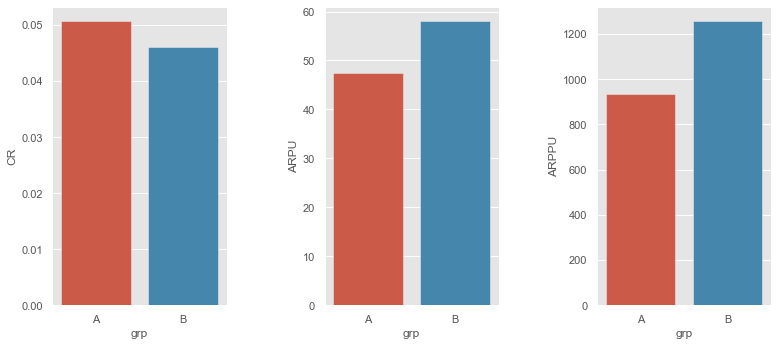

In [58]:
def draw_plots(CR, ARPU, ARPPU):
    fig, axs = plt.subplots(ncols=3)  # используется для вывода 3 графиков в одном окне
    sns.barplot(x='grp', y='CR', data=CR, ax=axs[0])
    sns.barplot(x='grp', y='ARPU', data=ARPU, ax=axs[1])
    sns.barplot(x='grp', y='ARPPU', data=ARPPU, ax=axs[2])
    fig.tight_layout(pad=5.0)  # добавляет расстояние между графиками
    # plt.show()
    print(fig)
        
        
draw_plots(CR, ARPU, ARPPU)